In [20]:
import argparse
import glob
import json
import os
from torchvision.transforms import transforms
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from collections import Counter
from pytorch_grad_cam import GradCAMPlusPlus
import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb
import albumentations as A
from PIL import Image
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF
from src.utils.transform_utils import load_transforms
from src.models.regnety.regnety import RegNetY

In [22]:
api = wandb.Api()
# run = api.run(f'mvrcii_/SEER/qt8ov5wo')
run = api.run(f'wuesuv/CV2024/qt8ov5wo')
config = argparse.Namespace(**run.config)

In [23]:
transforms_str = run.summary.get('transforms')
_, val_transform = load_transforms(img_size=config.img_size, transforms_string=transforms_str)
base_transform = val_transform

In [24]:
# Project paths
vissl_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\\vissl'
endoscopy_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\endoscopy'
cvip_project_dir = 'C:\\Users\Marce\Git-Master\Privat\cv2024'

In [25]:
class_mapping_path = os.path.join(endoscopy_project_dir, 'datasets/endoextend_dataset/class_mapping.json')
absolute_path = os.path.abspath(class_mapping_path)
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

In [26]:
# ckpt_filename = 'run-20240826_194035-ancient-forest-381/best_epoch92_val_f1_weighted0.84.ckpt'
ckpt_filename = 'run-20240827_135850-honest-salad-51/best_epoch07_val_AUC_macro0.99.ckpt'
ckpt_path = os.path.join(cvip_project_dir, 'pretrained_models', ckpt_filename)

model = RegNetY.load_from_checkpoint(checkpoint_path=ckpt_path, config=config, class_to_idx=class_mapping)
model.to(torch.device('cuda'))
model.eval();

In [27]:
# GradCAM
target_layers = [model.backbone.s4.b1.conv3.conv]
for param in model.backbone.s4.b1.conv3.conv.parameters():
    param.requires_grad = True

grad_cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

In [28]:
def revert_transformations(tensor):
    """Revert transformations applied during preprocessing, mainly normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor.mul_(std).add_(mean)  # Revert normalization
    return TF.to_pil_image(tensor.cpu())  # Convert to PIL Image for visualization

In [29]:
def load_and_transform_image(image_path, transform):
    with Image.open(image_path) as img:
        return transform(image=np.array(img.convert('RGB')))['image'].to(torch.device('cuda'))

In [26]:
def create_tta_transforms(base_transform, num_variants=5):
    tta_transforms = [base_transform]
    for _ in range(num_variants):
        tta_transform = A.Compose([
            A.OneOf([  
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=10, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ], p=1),  
            base_transform,
        ])
        tta_transforms.append(tta_transform)
    return tta_transforms

In [ ]:
def predict_images_with_tta(model, image_paths, batch_size=32, num_augmentations=5, revert_transform=False):
    """Predict classes for a list of image paths using TTA."""
    final_predictions = []
    image_list = []  # Store tensors for return
    tta_transforms = create_tta_transforms(base_transform, num_augmentations)  # Create TTA transforms

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_predictions = []
        for tta_transform in tta_transforms:
            batch_tensor, tensor_images = load_and_transform_image(batch_paths, tta_transform)
            with torch.no_grad():
                logits = model(batch_tensor)
                preds = logits.argmax(dim=1).cpu().numpy()
                batch_predictions.append(preds)
                if revert_transform:
                    tensor_images = [revert_transformations(tensor) for tensor in tensor_images]
                image_list.extend(tensor_images)
        # Average predictions across TTA for each image
        batch_predictions = np.array(batch_predictions)
        averaged_predictions = np.mean(batch_predictions, axis=0).astype(int)
        final_predictions.extend(averaged_predictions)

    return final_predictions, image_list

In [30]:
def predict_image(model, val_transform, image_path):
    img_tensor = load_and_transform_image(image_path, val_transform)
    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0)).squeeze()
        preds = logits.argmax(dim=0).cpu().numpy()
        probs = torch.softmax(logits, dim=0).detach().cpu().numpy()
        return preds, img_tensor, probs

In [31]:
def list_image_files(path: str, extensions=None) -> list:
    """List all image files in a directory, handling multiple extensions."""
    if extensions is None:
        extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.gif']
    images = []
    for extension in extensions:
        images.extend(glob.glob(os.path.join(path, '**', '*' + extension), recursive=True))
    return images

In [32]:
def idx_to_label(idx, class_mapping):
    return {v: k for k, v in class_mapping.items()}[idx]

In [33]:
# Load all foreign_body images
cvip_imgs = list_image_files('cvip')
ee_imgs = list_image_files('endoextend')

# Identify common filenames
filenames1 = {os.path.basename(path) for path in cvip_imgs}
filenames2 = {os.path.basename(path) for path in ee_imgs}
common_filenames = filenames1.intersection(filenames2)

# Extract common images
cvip_images = [path for path in cvip_imgs if os.path.basename(path) in common_filenames]
ee_images = [path for path in ee_imgs if os.path.basename(path) in common_filenames]

In [34]:
def compare_images(ee_tensor, cvip_tensor):
    print(ee_tensor.shape, cvip_tensor.shape)

    # Ensure both tensors are of the same shape and on the same device
    assert ee_tensor.shape == cvip_tensor.shape, "Input tensors must have the same shape."
    ee_tensor = ee_tensor.to(cvip_tensor.device)

    # Remove the batch dimension if present
    ee_tensor = ee_tensor.squeeze(0)
    cvip_tensor = cvip_tensor.squeeze(0)

    # Convert tensors to numpy arrays for some of the metrics
    ee_image = ee_tensor.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]
    cvip_image = cvip_tensor.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]

    # Calculate an appropriate window size for SSIM
    ssim_value = ssim(ee_image, cvip_image, win_size=7, data_range=np.max(ee_image) - np.min(ee_image),
                      multichannel=True, channel_axis=2)

    # 1. Mean Squared Error (MSE)
    mse = F.mse_loss(ee_tensor, cvip_tensor).item()
    print(f'Mean Squared Error (MSE): {mse}')

    # 2. Peak Signal-to-Noise Ratio (PSNR)
    max_pixel_value = 1.0  # Assuming images are normalized [0, 1]
    mse_tensor = torch.tensor(mse)  # Convert MSE to a tensor
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse_tensor)
    print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr.item()} dB')

    if ssim_value is not None:
        print(f'Structural Similarity Index (SSIM): {ssim_value}')
    else:
        print("SSIM calculation was skipped due to small image dimensions.")

    # 4. Cosine Similarity
    ee_tensor_flat = ee_tensor.flatten()
    cvip_tensor_flat = cvip_tensor.flatten()
    cosine_similarity = F.cosine_similarity(ee_tensor_flat, cvip_tensor_flat, dim=0)
    print(f'Cosine Similarity: {cosine_similarity.item()}')

EndoExtend Probabilities:
 ['0.0207', '0.0134', '0.2783', '0.0251', '0.0863', '0.0145', '0.0458', '0.5058', '0.0093', '0.0007']
CVIP Probabilities:
 ['0.0070', '0.0044', '0.1698', '0.0235', '0.7056', '0.0098', '0.0138', '0.0588', '0.0071', '0.0002']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.025145864114165306
Peak Signal-to-Noise Ratio (PSNR): 15.99533462524414 dB
Structural Similarity Index (SSIM): 0.4032222330570221
Cosine Similarity: 0.8980046510696411


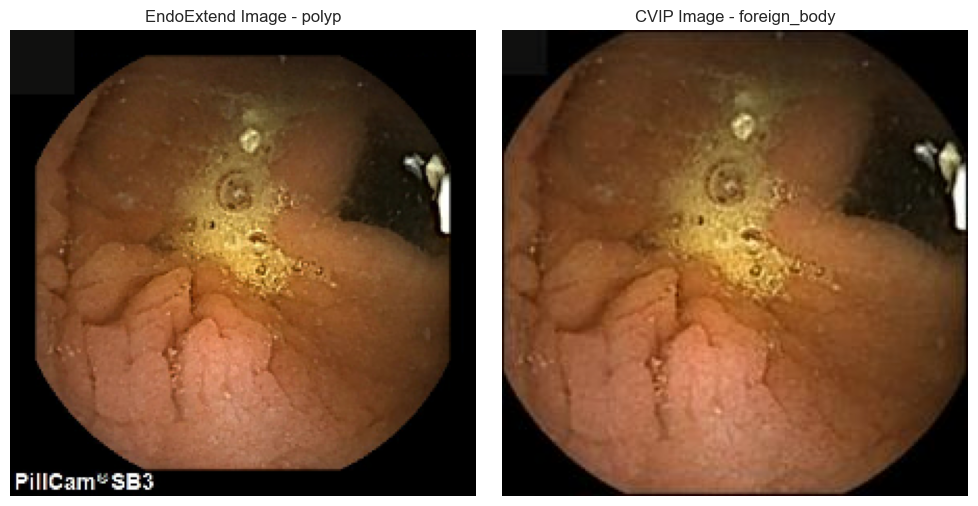

EndoExtend Probabilities:
 ['0.0714', '0.0594', '0.1562', '0.0296', '0.4367', '0.0434', '0.0306', '0.1650', '0.0067', '0.0011']
CVIP Probabilities:
 ['0.0518', '0.0142', '0.4926', '0.0332', '0.2480', '0.0936', '0.0186', '0.0449', '0.0028', '0.0002']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.04166789352893829
Peak Signal-to-Noise Ratio (PSNR): 13.801984786987305 dB
Structural Similarity Index (SSIM): 0.31842198967933655
Cosine Similarity: 0.73564612865448


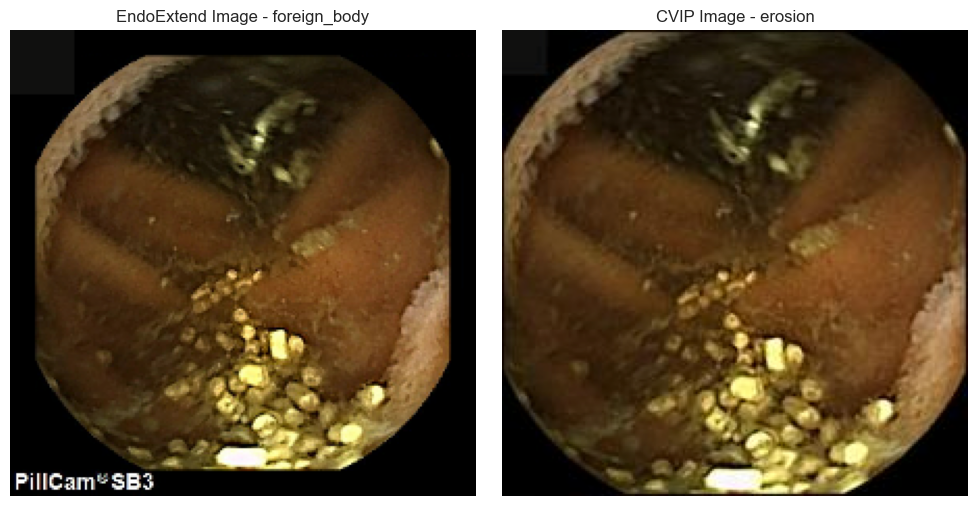

EndoExtend Probabilities:
 ['0.0144', '0.0377', '0.0525', '0.0132', '0.7440', '0.0130', '0.0626', '0.0497', '0.0099', '0.0030']
CVIP Probabilities:
 ['0.0043', '0.0043', '0.0241', '0.0078', '0.9313', '0.0079', '0.0087', '0.0089', '0.0023', '0.0004']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.04607166722416878
Peak Signal-to-Noise Ratio (PSNR): 13.365660667419434 dB
Structural Similarity Index (SSIM): 0.3045673072338104
Cosine Similarity: 0.7576253414154053


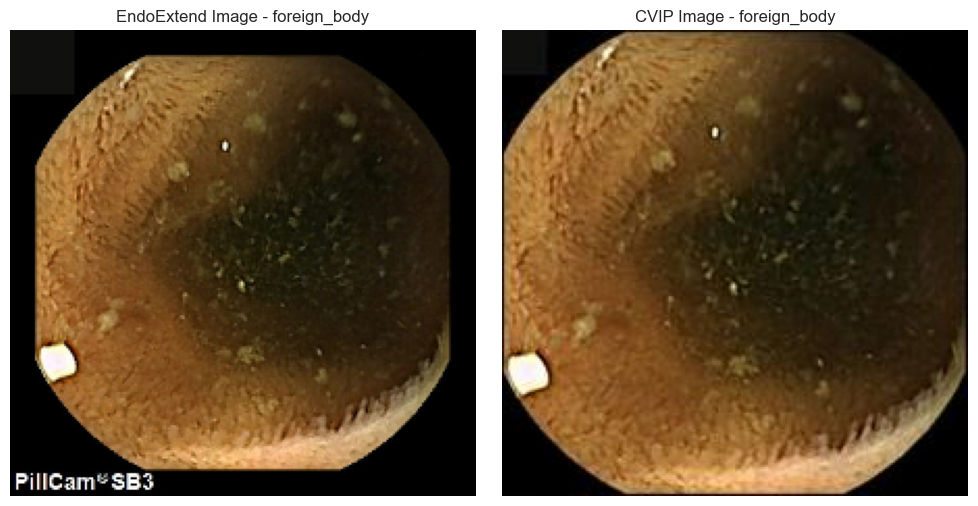

EndoExtend Probabilities:
 ['0.0108', '0.0025', '0.8035', '0.1512', '0.0038', '0.0018', '0.0045', '0.0176', '0.0044', '0.0000']
CVIP Probabilities:
 ['0.0042', '0.0008', '0.9752', '0.0135', '0.0007', '0.0004', '0.0012', '0.0020', '0.0019', '0.0000']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.019630292430520058
Peak Signal-to-Noise Ratio (PSNR): 17.07073211669922 dB
Structural Similarity Index (SSIM): 0.3745756447315216
Cosine Similarity: 0.9256465435028076


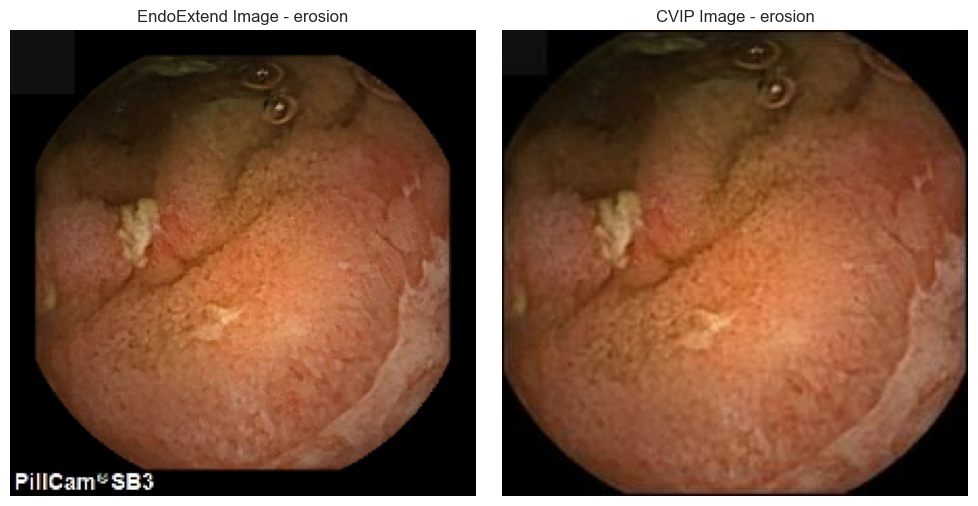

EndoExtend Probabilities:
 ['0.0028', '0.0018', '0.0073', '0.0160', '0.9540', '0.0027', '0.0027', '0.0117', '0.0011', '0.0001']
CVIP Probabilities:
 ['0.0087', '0.0074', '0.0232', '0.0189', '0.8898', '0.0070', '0.0062', '0.0363', '0.0021', '0.0003']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.02189631015062332
Peak Signal-to-Noise Ratio (PSNR): 16.596290588378906 dB
Structural Similarity Index (SSIM): 0.40232768654823303
Cosine Similarity: 0.8328430652618408


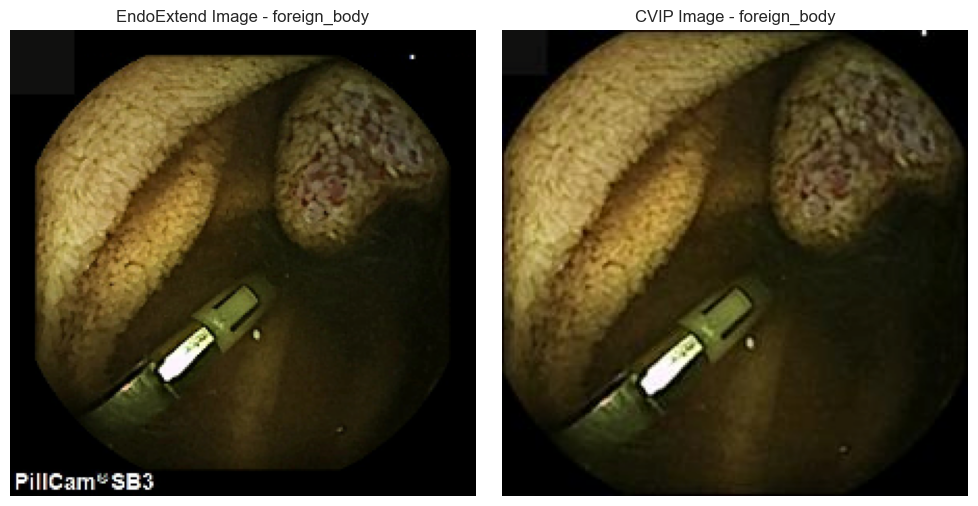

In [35]:
def plot_image_idx(ee_path, cvip_path):
    cvip_pred, cvip_tensor, cvip_probs = predict_image(model=model, image_path=cvip_path,
                                                       val_transform=base_transform)
    ee_pred, ee_tensor, ee_probs = predict_image(model=model, image_path=ee_path,
                                                 val_transform=base_transform)

    print("EndoExtend Probabilities:\n", [f"{p:.4f}" for p in ee_probs])
    print("CVIP Probabilities:\n", [f"{p:.4f}" for p in cvip_probs])

    cvip_img = revert_transformations(cvip_tensor)
    ee_img = revert_transformations(ee_tensor)

    transform = transforms.ToTensor()
    cvip_tensor = transform(cvip_img).unsqueeze(0)
    ee_tensor = transform(ee_img).unsqueeze(0)

    compare_images(cvip_tensor=cvip_tensor, ee_tensor=ee_tensor)

    cvip_pred_label = idx_to_label(cvip_pred.item(), class_mapping)
    ee_pred_label = idx_to_label(ee_pred.item(), class_mapping)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(ee_img)
    axes[0].set_title(f'EndoExtend Image - {ee_pred_label}')  # Include predicted label in title
    axes[0].axis('off')  # Hide axes

    # Display CVIP image with predicted label
    axes[1].imshow(cvip_img)
    axes[1].set_title(f'CVIP Image - {cvip_pred_label}')  # Include predicted label in title
    axes[1].axis('off')  # Hide axes

    # Show the plot
    plt.tight_layout()
    plt.show()


for i in range(0, 5):
    plot_image_idx(ee_path=ee_images[i], cvip_path=cvip_images[i])

In [ ]:
cvip_predictions, _ = predict_images_with_tta(model=model, image_paths=cvip_images, revert_transform=False)
print(Counter(cvip_predictions))

In [ ]:
cvip_predictions, _ = predict_images(model=model, image_paths=cvip_images, val_transform=base_transform,
                                     revert_transform=False)
print(Counter(cvip_predictions))

In [ ]:
ee_predictions, _ = predict_images_with_tta(model=model, image_paths=ee_images[:64], revert_transform=False)
print(Counter(ee_predictions))

In [ ]:
ee_predictions, _ = predict_images(model=model, image_paths=ee_images[:64], val_transform=base_transform,
                                   revert_transform=False)
print(Counter(ee_predictions))